In [1]:
import BlackScholes as bs
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import risk_free_rates as rf
import implied_q as iq
import time
import pymc as pm
import pytensor.tensor as pt
import variance_curve as vc

from rbergomi import rBergomi

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read the dataset

S0 = 4017.8

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

maturities = maturities[1:11]
IV = IV[1:11,:]

K = S0 * moneyness / 100

# Starting parameters from deterministic calibration
data = pd.read_csv("rB_parameters.csv")

In [3]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
nr = len(maturities); nc = len(K);
N = 15000; n = 365;
steps = np.ceil(n*maturities).astype(int)
T = maturities[-1]
np.random.seed(0)

p = np.zeros([nr,nc])

for i in range(nr):
    tau = maturities[i]
    for j in range(nc):
        p[i,j] = bs.BSCall(S0, K[j], tau, rf.r(maturities[i]), iq.q(maturities[i]), IV[i,j])

true_price = p.flatten()

In [5]:
def f(H, eta, rho, sixe = None):
    
    P = np.zeros([nr, nc])
    
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0])
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps)
    
    for i in range(nr):
        aux_T = maturities[i]
        r = rf.r(aux_T); q = iq.q(aux_T);
        P[i,:] = price(S[i,:], K, r, q, aux_T)
    
    return P.flatten()

In [6]:
t = time.time()
a = f(0.01, 1.7, -0.9)
print(f'Elapsed time: {time.time()-t: .2f}s')

Elapsed time:  0.63s


In [7]:
def f(rng, H, eta, rho, sixe = None):
    
    P = np.zeros([nr, nc])
    
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0])
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps)
    
    for i in range(nr):
        aux_T = maturities[i]
        r = rf.r(aux_T); q = iq.q(aux_T);
        P[i,:] = price(S[i,:], K, r, q, aux_T)
    
    return P.flatten()

In [9]:
start_time = time.time()

with pm.Model() as model_lv:
    
    H = pm.Uniform("H", lower = 1e-5, upper = 0.15)
    eta = pm.Uniform("eta", lower = 1, upper = 5)
    rho = pm.Uniform("rho", lower = -1, upper = -1e-5)

    sim = pm.Simulator("sim", f, params = (H, eta, rho), epsilon = 10, observed = true_price)

    idata_lv = pm.sample_smc(draws = 2000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  67560.50s


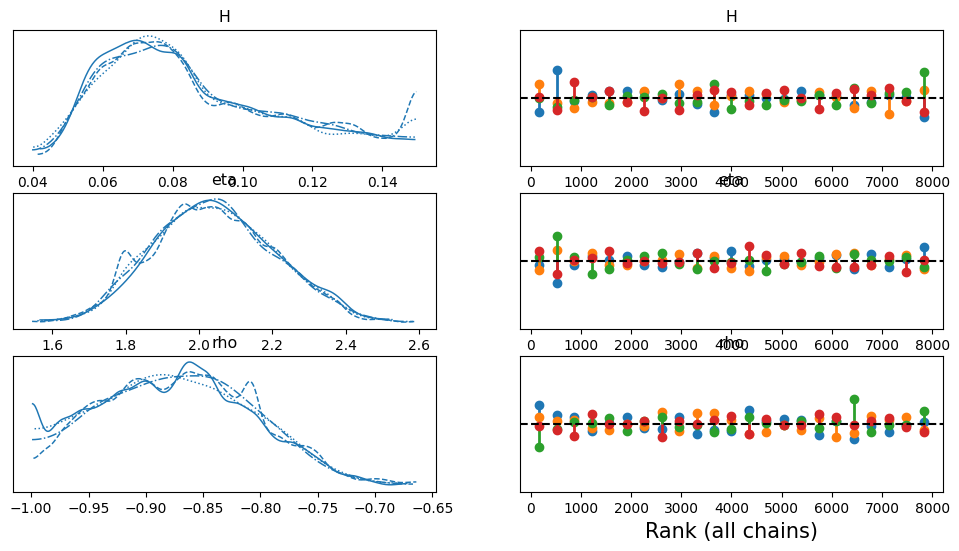

In [10]:
az.plot_trace(idata_lv, kind="rank_vlines");

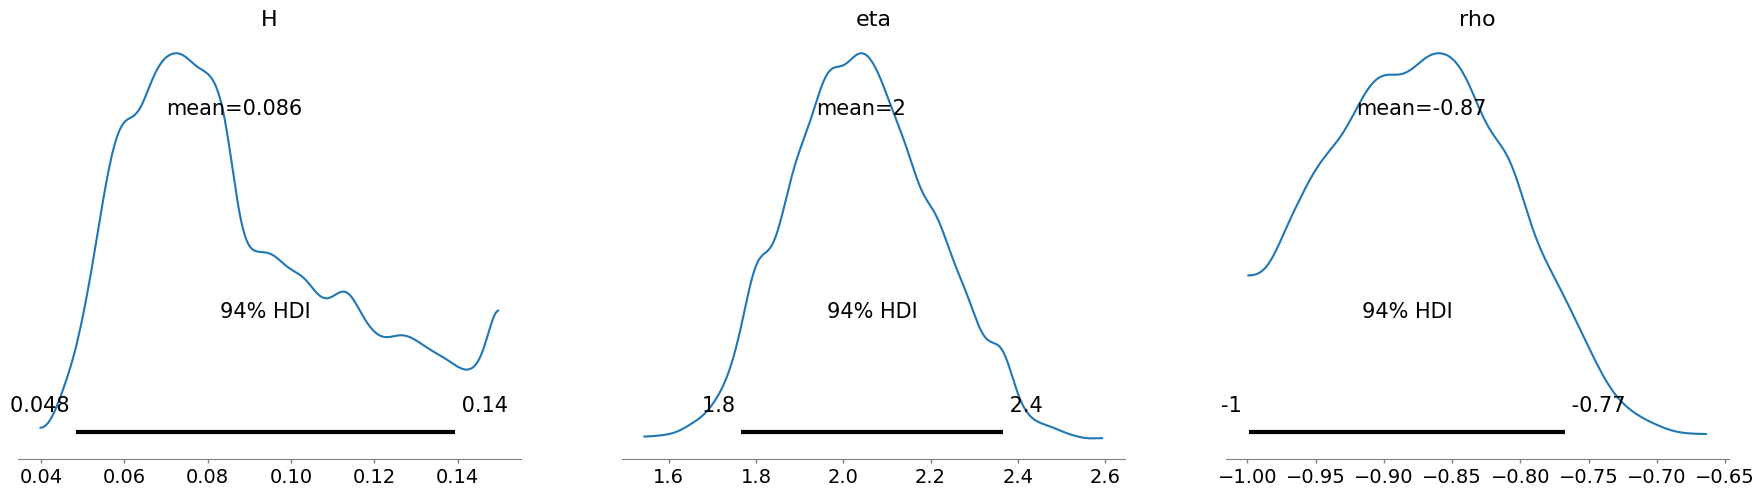

In [11]:
az.plot_posterior(idata_lv);

In [12]:
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()
H = np.array(pd.DataFrame(idata_lv.posterior.H)).flatten()
eta = np.array(pd.DataFrame(idata_lv.posterior.eta)).flatten()

Rho: -0.854017216003975


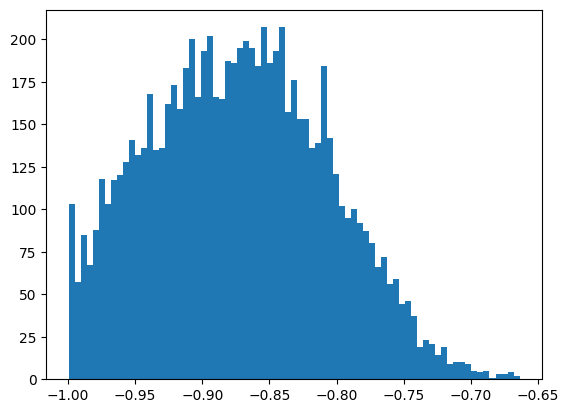

In [13]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("Rho:", x_max)

H: 0.06688238300991937


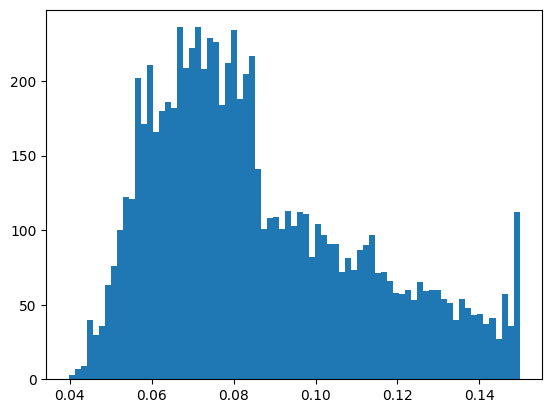

In [14]:
a = plt.hist(H, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("H:", x_max)

Eta: 1.9707188371581137


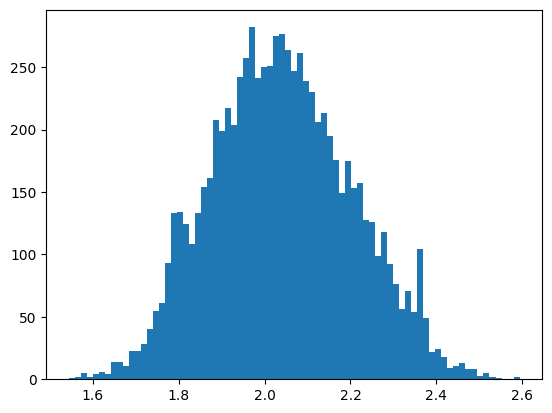

In [15]:
a = plt.hist(eta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = x[np.argmax(y)]
print("Eta:", x_max)